In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import pandas as pd
from plot import *
from analyze import *

/tmp/ipykernel_22062/645144142.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:

def postprocess_df(series, exclude_keys=None):
    """
    Takes a pandas Series with a MultiIndex and folds over all keys except for those specified
    in `exclude_keys` by concatenating the key name and its value into the 'algo' column values.

    Parameters:
    - series: pandas.Series with a MultiIndex.
    - exclude_keys: list of strings representing keys to exclude from the folding process.

    Returns:
    - A DataFrame with 'algo' and 'dataset' columns, where 'algo' has been modified to include
      information from other keys.
    """

    if exclude_keys is None:
      exclude_keys=['algo', 'dataset', 'final_acc']
    # Convert the Series into a DataFrame
    df = series.reset_index()
    
    # # Initialize a column to store the modified algo values
    df['modified_algo'] = df['algo']
    exclude_keys += ['modified_algo']
    
    # # Iterate over each level of the original MultiIndex (now columns in df)
    for key in df.columns:
        if key not in exclude_keys:
            # Append the key name and its value to the 'modified_algo' entries
            df['modified_algo'] = df['modified_algo'] + '_' + key + ':' + df[key].astype(str)
    
    # # Select and rename the relevant columns for the final DataFrame
    final_df = df[['modified_algo', 'dataset', series.name]].copy()
    final_df.rename(columns={'modified_algo': 'algo', series.name: 'value'}, inplace=True)
    
    return final_df

def aggregate_results(df, keys=None, metric=None, post_process=True,
                      error_type="sem"):
   if keys is None:
      keys = ["algo", "use_contrastive"]
   if metric is None:
      metric = "final_acc"
   keys += ["dataset"]
   m = df.groupby(keys)[
         metric].mean()
   if error_type == "sem":
      stderr = df.groupby(keys)[metric].sem()
   else:
      stderr = df.groupby(keys)[metric].std()
   if post_process:
      exclude_keys=["algo", "dataset", metric]
      m = postprocess_df(m, exclude_keys)
      stderr = postprocess_df(stderr, exclude_keys)
   return m, stderr


def plot_bar_res(df, color_map=None, edgecolor_map=None, bar_width=0.2, keys=None,
      metric=None,
      remap_name=None,
      hatch_map=None,
      y_min=None,
      y_max=None,
      error_type='sem',
      name='results',
      y_label="Accuracy"):
    """
    Corrected plotting function that properly handles DataFrame structures.
    """
    m, stderr = aggregate_results(df, keys=keys, metric=metric,
                                  error_type=error_type)

    # Extract unique datasets and algorithms for plotting
    datasets = sorted(m['dataset'].unique())[::-1]
    algos = sorted(m['algo'].unique())[::-1]

    # Set figure size and plot properties
    fig, ax = plt.subplots(figsize=(15, 5))
    opacity = 0.8
    linewidth = 2


    print(m)
    print(stderr)
    for i, algo in enumerate(algos):
        positions = np.arange(len(datasets)) + i * bar_width
        # Filter rows for the current algorithm
        algo_means = m[m['algo'] == algo].set_index('dataset')['value'].reindex(datasets).values
        algo_stderr = stderr[stderr['algo'] == algo].set_index('dataset')['value'].reindex(datasets).values

        ax.bar(positions, algo_means, bar_width, yerr=algo_stderr, alpha=opacity, label=remap_name[algo] if remap_name is not None else algo,
               color=color_map[algo] if color_map is not None else None, 
               linewidth=linewidth,
               edgecolor=edgecolor_map[algo] if edgecolor_map is not None else None,
               hatch=hatch_map[algo] if hatch_map is not None else None,
               capsize=5)

    # Set x-axis labels, titles, and legend
    ax.set_xticks(np.arange(len(datasets)) + bar_width * (len(algos) - 1) / 2)
    ax.set_xticklabels(datasets, fontsize=14)
    if y_min is not None and y_max is not None:
        ax.set_ylim([y_min, y_max])
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_xlabel('Dataset', fontsize=14)

    # if metric contain any _, we need to replace them with \_ for latex
    metric = metric.replace("_", r"\_")
    ax.set_title(
        r'Comparison of $\mathsf{'+metric+'}$ across datasets', fontsize=16, weight='bold')
    ax.legend(frameon=True, loc='lower right', bbox_to_anchor=(1.1, 0.0))
    ax.grid(True, which='major', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig(f"Figures/{name}.pdf", bbox_inches="tight")




def plot_bar_separate(df, color_map=None, edgecolor_map=None, bar_width=0.2, keys=None,
                      metric=None, remap_name=None, hatch_map=None, y_min=None, y_max=None,
                      error_type='sem'):
    """
    Plotting function that creates a separate subplot for each dataset, comparing all algorithms.
    """
    m, stderr = aggregate_results(df, keys=keys, metric=metric,
                                  error_type=error_type)

    # Extract unique datasets and algorithms for plotting
    datasets = sorted(m['dataset'].unique())
    algos = sorted(m['algo'].unique())

    # Create a figure with a subplot for each dataset
    n_datasets = len(datasets)
    fig, axes = plt.subplots(1, n_datasets, figsize=(5 * n_datasets, 5))
    
    if n_datasets == 1:
        axes = [axes]  # Make sure axes is always iterable

    opacity = 0.8
    linewidth = 2

    for idx, dataset in enumerate(datasets):
        ax = axes[idx]  # Select the corresponding subplot for the dataset
        # Generate positions for each algorithm uniquely within the subplot
        d_m = m[m['dataset'] == dataset]
        d_err = stderr[stderr['dataset'] == dataset]
        # make the positions tighter
        positions = np.arange(len(d_m['value'])) * bar_width
        ax.bar(positions, d_m['value'], bar_width, yerr=d_err['value'], alpha=opacity,
        label=[remap_name[algo] if remap_name is not None else algo for algo in d_m['algo']],
               color=[color_map[algo] for algo in d_m['algo']],
               linewidth=linewidth,
               edgecolor=[edgecolor_map[algo] for algo in d_m['algo']],
               hatch=[hatch_map[algo] for algo in d_m['algo']],
               capsize=5)
        # no need to set xticks
        ax.set_xticks([])
        ax.set_title(dataset, fontsize=16)
        if y_min is not None and y_max is not None:
                ax.set_ylim([y_min, y_max])

    # fig.text(0.5, 0.04, 'Algorithms', ha='center', va='center', fontsize=14)
    # fig.text(0.04, 0.5, 'Accuracy', va='center', ha='center', rotation='vertical', fontsize=14)
    fig.suptitle(f'Comparison of {metric.replace("_", " ").title()} Across Datasets', fontsize=16, weight='bold')
    axes[-1].legend(frameon=True, loc='upper left', bbox_to_anchor=(1.05, 1))

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout
    plt.savefig("Figures/results_per_dataset.pdf", bbox_inches="tight")

In [3]:
def format_df_for_table(m):
    res = m.copy()
    # Remove the "_use_contrastive:False" part for cleaner extraction
    res['algo_clean'] = res['algo'].str.replace('_use_contrastive:False', '')

    # Now, extract 'base' and 'algorithm' accurately
    res['base'] = res['algo_clean'].str.extract(r'^([^_]+)')[0]
    res['algorithm'] = res['algo_clean'].str.extract(r'_(.+)$')[0]

    # Fill NaN in 'algorithm' with 'vanilla'
    res['algorithm'].fillna('vanilla', inplace=True)

    # Drop the columns we don't need anymore
    res.drop(['algo', 'algo_clean'], axis=1, inplace=True)

    res = res.pivot_table(index=['base', 'algorithm'], columns='dataset', values='value', aggfunc='first').reset_index()
    return res

In [4]:
color_map = {
   'modular_use_contrastive:False': '#3182bd',
   'monolithic_use_contrastive:False': '#de2d26',
   'modular_modmod_use_contrastive:False':  '#214073',  # Corrected key
   'modular_fedavg_use_contrastive:False': '#6a9bbd',  # Changed key format
   'monolithic_fedavg_use_contrastive:False': '#a50f15',  # Changed key format
   'modular_recv_use_contrastive:False': '#08519c',  # Changed key format
   'monolithic_recv_use_contrastive:False': '#cb181d',  # Changed key format
}

edgecolor_map = {
   'modular_use_contrastive:False': '#214073',
   'monolithic_use_contrastive:False': '#a6221f',
   'modular_modmod_use_contrastive:False':  '#08306b',  # Corrected key
   'modular_fedavg_use_contrastive:False': '#4292c6',  # Changed key format
   'monolithic_fedavg_use_contrastive:False': '#67000d',  # Changed key format
   'modular_recv_use_contrastive:False': '#04386a',  # Changed key format
   'monolithic_recv_use_contrastive:False': '#b2171d',  # Changed key format
}

remap_name = {
   'modular_use_contrastive:False': 'modular (baseline)',
   'monolithic_use_contrastive:False': 'monolithic (baseline)',
   'modular_modmod_use_contrastive:False':  'modmod',  # Corrected key
   'modular_fedavg_use_contrastive:False': 'modular FedAvg',  # Changed key format
   'monolithic_fedavg_use_contrastive:False': 'monolithic FedAvg',  # Changed key format
   'modular_recv_use_contrastive:False': 'modular data',  # Changed key format
   'monolithic_recv_use_contrastive:False': 'monolithic data',  # Changed key format
}


hatch_map = {
   'modular_use_contrastive:False': '',
   'monolithic_use_contrastive:False': '',
   'modular_modmod_use_contrastive:False':  '/',  # Corrected key
   'modular_fedavg_use_contrastive:False': '.',  # Changed key format
   'monolithic_fedavg_use_contrastive:False': '.',  # Changed key format
   'modular_recv_use_contrastive:False': '+',  # Changed key format
   'monolithic_recv_use_contrastive:False': '+',  # Changed key format
}

In [5]:
root_save_dir = "experiment_results"
vanilla_path = "vanilla_jorge_setting_basis_no_sparse"
fed_path = "jorge_setting_fedavg"
recv_path = "jorge_setting_recv"

leep_modmod = 'leep_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True'
modmod = 'jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True'

vanilla_path = os.path.join(root_save_dir, vanilla_path)
# fed_path = os.path.join(root_save_dir, fed_path)
# recv_path = os.path.join(root_save_dir, recv_path)

# leep_modmod = os.path.join(root_save_dir, leep_modmod)
# modmod = os.path.join(root_save_dir, modmod)

In [6]:
analyze(vanilla_path)
# analyze(fed_path)
# analyze(recv_path)
# analyze(leep_modmod)
# analyze(modmod)

In [7]:
# leep_modmod_df = pd.read_csv(leep_modmod + ".csv")
# leep_modmod_df = leep_modmod_df[leep_modmod_df['dataset'] == 'combined']
# modmod_df = pd.read_csv(modmod + ".csv")
# modmod_df = pd.concat([leep_modmod_df, modmod_df])

In [10]:
vanilla_df = pd.read_csv(vanilla_path + ".csv")
# fed_df = pd.read_csv(fed_path + ".csv")
# recv_df = pd.read_csv(recv_path + ".csv")

In [11]:
# filter vanilla_df to only include `use_contrastive` = False
vanilla_df = vanilla_df[vanilla_df['use_contrastive'] == False]
# modmod_df = modmod_df[modmod_df['use_contrastive'] == False]
# fed_df = fed_df[fed_df['use_contrastive'] == False]
# recv_df = recv_df[recv_df['use_contrastive'] == False]

In [12]:
vanilla_df.groupby(['algo', 'dataset']).mean().reset_index()

/tmp/ipykernel_22062/2486868112.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  vanilla_df.groupby(['algo', 'dataset']).mean().reset_index()


,algo,dataset,final_acc,auc,use_contrastive
0,modular,cifar100,0.700353,71.830949,0.0
1,modular,combined,0.885849,88.045240,0.0
2,modular,fashionmnist,0.928013,92.030353,0.0
3,modular,kmnist,0.806317,80.623203,0.0
4,modular,mnist,0.934668,92.678577,0.0
5,monolithic,cifar100,0.631084,65.597685,0.0
6,monolithic,combined,0.865895,87.694882,0.0
7,monolithic,fashionmnist,0.924673,93.271096,0.0
8,monolithic,kmnist,0.782273,79.418373,0.0
9,monolithic,mnist,0.919588,93.102307,0.0


In [13]:
# fed_df['algo'] = fed_df['algo'] + '_fedavg'
# modmod_df['algo'] = modmod_df['algo'] + '_modmod'
# recv_df['algo'] = recv_df['algo'] + '_recv'

In [15]:
df

,final_acc,auc,dataset,algo,use_contrastive,seed,agent_id
128,0.940752,93.999458,mnist,monolithic,False,seed_4,agent_1
129,0.920102,92.827794,mnist,monolithic,False,seed_4,agent_2
130,0.944341,95.238666,mnist,monolithic,False,seed_4,agent_6
131,0.914794,92.486923,mnist,monolithic,False,seed_4,agent_7
132,0.912133,92.662583,mnist,monolithic,False,seed_4,agent_4
...,...,...,...,...,...,...,...
1211,0.785850,80.215900,kmnist,monolithic,False,seed_0,agent_7
1212,0.795900,81.317085,kmnist,monolithic,False,seed_0,agent_4
1213,0.775800,80.745433,kmnist,monolithic,False,seed_0,agent_3
1214,0.851250,85.170857,kmnist,monolithic,False,seed_0,agent_0


                               algo       dataset     value
0     modular_use_contrastive:False      cifar100  0.700353
1     modular_use_contrastive:False      combined  0.885849
2     modular_use_contrastive:False  fashionmnist  0.928013
3     modular_use_contrastive:False        kmnist  0.806317
4     modular_use_contrastive:False         mnist  0.934668
5  monolithic_use_contrastive:False      cifar100  0.631084
6  monolithic_use_contrastive:False      combined  0.865895
7  monolithic_use_contrastive:False  fashionmnist  0.924673
8  monolithic_use_contrastive:False        kmnist  0.782273
9  monolithic_use_contrastive:False         mnist  0.919588
                               algo       dataset     value
0     modular_use_contrastive:False      cifar100  0.001357
1     modular_use_contrastive:False      combined  0.003560
2     modular_use_contrastive:False  fashionmnist  0.003087
3     modular_use_contrastive:False        kmnist  0.003094
4     modular_use_contrastive:False     

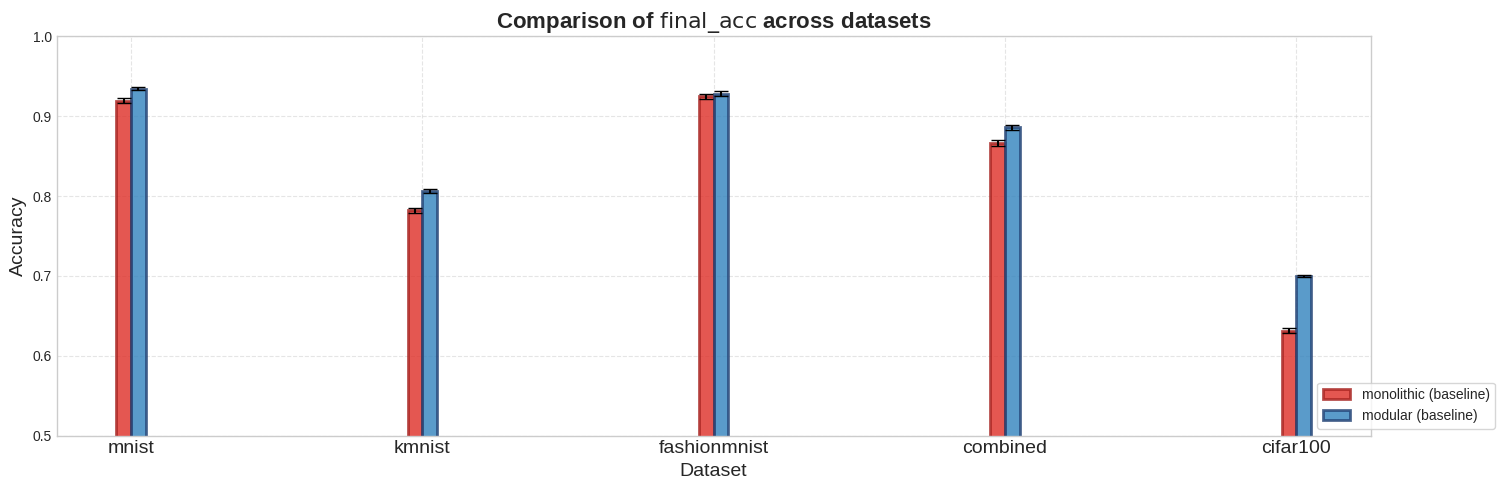

In [16]:
plot_bar_res(df, bar_width=0.05, color_map=color_map, edgecolor_map=edgecolor_map,
# plot_bar_separate(df, bar_width=0.1, color_map=color_map, edgecolor_map=edgecolor_map,
remap_name=remap_name, hatch_map=hatch_map, metric='final_acc',
y_min=0.5,
y_max=1.0,
error_type='sem',
name='all_methods_final_acc')

In [ ]:
# plot_bar_res(vanilla_df, color_map=color_map, edgecolor_map=edgecolor_map)
plot_bar_res(df, bar_width=0.05, color_map=color_map, edgecolor_map=edgecolor_map,
remap_name=remap_name, hatch_map=hatch_map, metric='auc',
y_min=50,
y_max=100,
error_type='sem',
name='all_methods_auc',
y_label="AUC"
)

In [ ]:
m , stderr = aggregate_results(df, metric='final_acc')
pivot_m = format_df_for_table(m)
table = make_table(pivot_m)
print(table)

In [ ]:
m , stderr = aggregate_results(df, metric='auc')
pivot_m = format_df_for_table(m)
table = make_table(pivot_m)
print(table)